In [1]:
import pickle
import datetime

import numpy as np

import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf-py312\Lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.11.0+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.0+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=0
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
]

polarizations = [
    [couplings.polarization_σm, couplings.polarization_σp],
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
# ignore small decay to J=4
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=lindblad.DecayChannel(
        ground=1.0
        * states.CoupledBasisState(
            J=None,
            F=None,
            mF=None,
            F1=None,
            I1=None,
            I2=None,
            electronic_state=states.ElectronicState.X,
            v=1,
        ),
        excited=states.QuantumSelector(J=1, electronic=states.ElectronicState.B),
        branching=1e-2,
    ),
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [5]:
odepars = lindblad_julia.odeParameters(
    Ω0="ΩQ0*variable_on_off(t, ton0, toff0, phase0)",
    ΩQ0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    P0="sin(ω0*t + φ0)",
    Pσm0="P0>0",
    Pσp0="P0<=0",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    Ω1="ΩQ1*variable_on_off(t, ton1, toff1, phase1)",
    ΩQ1=1 * hamiltonian.Γ,
    δ1=0.0,
    P1="sin(ω1*t + φ1)",
    Pσm1="P1>0",
    Pσp1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # on/off parameters
    ton0=1e-6,
    toff0=1e-6,
    ton1=1e-6,
    toff1=1e-6,
    phase0=0.0,
    phase1=np.pi,
)

In [6]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break

ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    
ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

|B, J = 1, F₁ = 1/2, F = 0>  |B, J = 1, F₁ = 1/2, F = 1>
states                                                              
|X, J = 1>                          1.0                     0.999873
|X, J = 3>                          0.0                     0.000127

In [8]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

|B, J = 1, F₁ = 1/2, F = 0>  \
states                                                     
|X, J = 1, F₁ = 1/2, F = 0>                     0.000000   
|X, J = 1, F₁ = 1/2, F = 1>                     0.747254   
|X, J = 1, F₁ = 3/2, F = 1>                     0.252746   
|X, J = 1, F₁ = 3/2, F = 2>                     0.000000   
|X, J = 3, F₁ = 5/2, F = 2>                     0.000000   

                             |B, J = 1, F₁ = 1/2, F = 1>  
states                                                    
|X, J = 1, F₁ = 1/2, F = 0>                     0.218683  
|X, J = 1, F₁ = 1/2, F = 1>                     0.419126  
|X, J = 1, F₁ = 3/2, F = 1>                     0.074107  
|X, J = 1, F₁ = 3/2, F = 2>                     0.287957  
|X, J = 3, F₁ = 5/2, F = 2>                     0.000127

In [9]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

In [10]:
obe_system.H_symbolic

Matrix([
[     δ1 - 1336622.00964355,                           0,                          0,                         0,                           0,                          0,                           0,                          0,                          0,                          0,                           0,                          0,                0, 0,                           0, -1.37788886870928*Pσm1*Ω1,                          0, -1.37788886890229*Pσp1*Ω1],
[                         0,       δ1 - 1196891.51054382,                          0,                         0,                           0,                          0,                           0,                          0,                          0,                          0,                           0,                          0,                0, 0,  -0.859730554868388*Pσp0*Ω0,                         0,   1.34885002059568*Pσp1*Ω1,                         0],
[                         0,                 

In [11]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X),
    obe_system.QN,
)

In [12]:
odepars.ton0 = 2e-6
odepars.ton1 = 1e-6
odepars.toff0 = 1e-6
odepars.toff1 = 1e-6
odepars.phase0 = 0.0
odepars.phase1 = np.pi
odepars.ΩQ0 = hamiltonian.Γ
odepars.ΩQ1 = 0.3 * hamiltonian.Γ

In [13]:
best_params = {
    "ΩQ0": 0.537263872784822 * hamiltonian.Γ,
    "ΩQ1": 0.33719556689109215 * hamiltonian.Γ,
    "phase0": 5.565271107771116,
    "phase1": 6.283185307179586,
    "ω0": 8248907.341066567,
    "ω1": 6868208.248066838,
    "φ0": 5.778279231554964,
    "φ1": 4.615293282564441,
    "ton0": 9.169010241579062e-06,
    "toff0": 8.296757849047523e-07,
    "ton1": 2.3574285905598484e-06,
    "toff1": 1.7547460956302267e-06,
}
for param, value in best_params.items():
    setattr(odepars, param, value)

In [14]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 260e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)

In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)

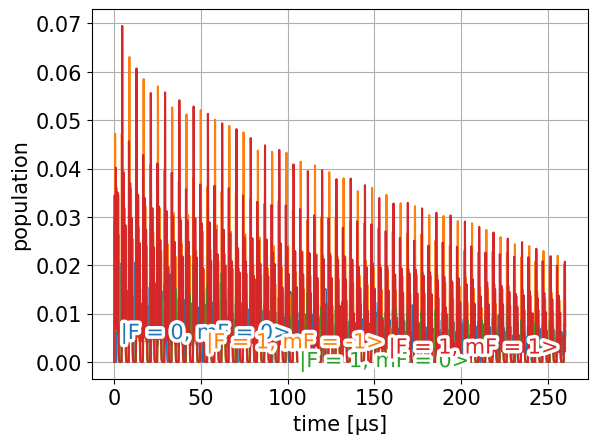

In [16]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"])
    for idx in indices_excited
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

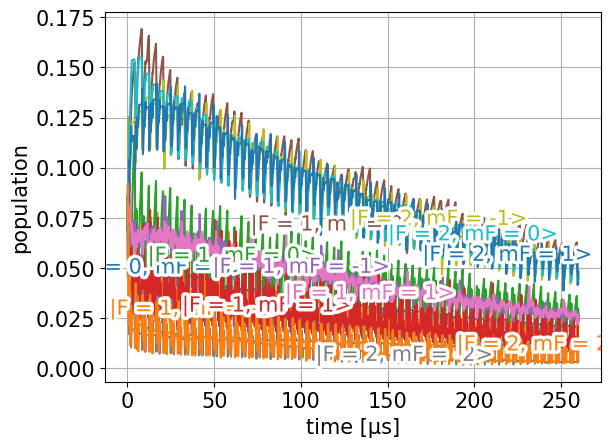

In [17]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J1
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J1].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

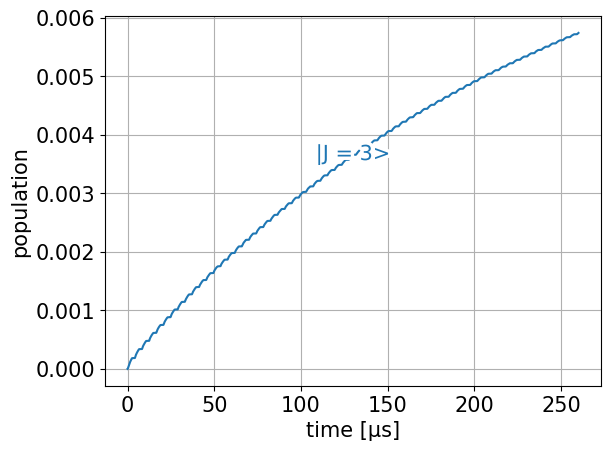

In [18]:
labels = [obe_system.QN[idx].largest.state_string_custom(["J"]) for idx in indices_J3]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J3].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()

In [19]:
from scipy.integrate import trapezoid

photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")
print(f"rate = {photons/problem.tspan[-1]:.2e} Hz")

# photons = 62.7
rate = 2.41e+05 Hz


# Parameter Scan

In [20]:
rabis0 = np.logspace(-1, 1, 5) * hamiltonian.Γ
rabis1 = np.logspace(-1, 1, 5) * hamiltonian.Γ
onoff = np.arange(1e-6, 10e-6 + 1e-7, 5e-7)
pol_freqs = np.linspace(0, 2e-6, 11) * 2 * np.pi


In [21]:
scan_values = [rabis0, rabis1, onoff, onoff]
parameters = ["ΩQ0", "ΩQ1", "ton0", "toff0", "ton1", "toff1"]


In [22]:
values = np.array(np.meshgrid(*scan_values, indexing="ij")).T.reshape(
    -1, len(scan_values)
)
values = np.hstack([values, values[:, -1][:, np.newaxis], values[:, -1][:, np.newaxis]])
values[:, -3] = values[:, -3]


In [23]:
save_idxs_excited = [
    v.item()
    for v in utils.population.get_diagonal_indices_flattened(
        size=len(obe_system.QN), states=indices_excited, mode="julia"
    )
]


In [24]:
output_function = lindblad_julia.setup_state_integral_calculation_state_idxs(
    nphotons=True, Γ=hamiltonian.Γ
)


In [25]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    distributed_method="EnsembleDistributed()",
    save_everystep=True,
    save_idxs=save_idxs_excited,
    callback=None,
    reltol=1e-3,
    abstol=1e-6,
    saveat=1e-6,
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=values.T,
    output_func=output_function,
    zipped=True,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)


In [26]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


CPU times: total: 3.17 s
Wall time: 12min 8s


In [27]:
results_scan = lindblad_julia.get_results_parameter_scan(ensemble_problem)

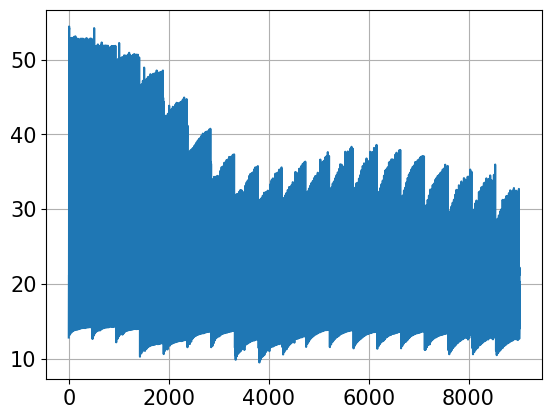

In [28]:
mask = np.s_[:]

fig, ax = plt.subplots()

ax.plot(results_scan.results[mask])

ax.grid()


# Bayesian Optimization

In [29]:
from ax import optimize

In [30]:
save_idxs_excited = [
    v.item()
    for v in utils.population.get_diagonal_indices_flattened(
        size=len(obe_system.QN), states=indices_excited, mode="julia"
    )
]


In [31]:
import copy
from julia import Main


def optimize_function(p):
    odepars_opt = copy.copy(odepars)
    odepars_opt.ton0 = p["ton0"]
    odepars_opt.ton1 = p["ton1"]
    odepars_opt.toff0 = p["toff0"]
    odepars_opt.toff1 = p["toff1"]
    odepars_opt.phase0 = p["phase0"]
    odepars_opt.phase1 = p["phase1"]
    odepars_opt.ΩQ0 = p["ΩQ0"] * hamiltonian.Γ
    odepars_opt.ΩQ1 = p["ΩQ1"] * hamiltonian.Γ
    odepars_opt.ω0 = p["ω0"]
    odepars_opt.ω1 = p["ω1"]
    odepars_opt.ϕ0 = p["ϕ0"]
    odepars_opt.ϕ1 = p["ϕ1"]

    problem = lindblad_julia.OBEProblem(odepars_opt, ρ, tspan=(0, 200e-6))
    config = lindblad_julia.OBEProblemConfig(
        saveat=1e-6,
        reltol=1e-3,
        abstol=1e-7,
        save_everystep=True,
        callback=None,
        save_idxs=save_idxs_excited,
    )
    lindblad_julia.setup_problem(
        problem.odepars, problem.tspan, problem.ρ, problem.name
    )
    lindblad_julia.solve_problem(problem, config)

    y = np.array(Main.eval("sol.u"))
    t = np.array(Main.eval("sol.t"))

    return trapezoid(y.sum(axis=1).real, x=t) * hamiltonian.Γ

In [32]:
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {
            "name": "ΩQ0",
            "type": "range",
            "bounds": [0.0, 2.0],
        },
        {
            "name": "ΩQ1",
            "type": "range",
            "bounds": [0.0, 2.0],
        },
        {
            "name": "phase0",
            "type": "range",
            "bounds": [0.0, 2 * np.pi],
        },
        {
            "name": "phase1",
            "type": "range",
            "bounds": [0.0, 2 * np.pi],
        },
        {
            "name": "ω0",
            "type": "range",
            "bounds": [0.0, 2 * np.pi * 2e6],
        },
        {
            "name": "ω1",
            "type": "range",
            "bounds": [0.0, 2 * np.pi * 2e6],
        },
        {
            "name": "ϕ0",
            "type": "range",
            "bounds": [0.0, 2 * np.pi],
        },
        {
            "name": "ϕ1",
            "type": "range",
            "bounds": [0.0, 2 * np.pi],
        },
        {
            "name": "ton0",
            "type": "range",
            "bounds": [0.0, 20e-6],
        },
        {
            "name": "toff0",
            "type": "range",
            "bounds": [0.0, 20e-6],
        },
        {
            "name": "ton1",
            "type": "range",
            "bounds": [0.0, 20e-6],
        },
        {
            "name": "toff1",
            "type": "range",
            "bounds": [0.0, 20e-6],
        },
    ],
    # Booth function
    evaluation_function=optimize_function,
    minimize=False,
    total_trials=300,
)


[INFO 10-10 23:00:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ΩQ0. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-10 23:00:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter ΩQ1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-10 23:00:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter phase0. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-10 23:00:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter phase1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict

In [33]:
best_values

({'objective': np.float64(57.00510835424269)},
 {'objective': {'objective': np.float64(0.17686203904340203)}})

In [34]:
best_parameters

{'ΩQ0': 0.7394276808581172,
 'ΩQ1': 0.1994112991346984,
 'phase0': 0.0,
 'phase1': 6.283185307179586,
 'ω0': 12566370.614359172,
 'ω1': 4359379.258982877,
 'ϕ0': 0.0,
 'ϕ1': 6.283185307179586,
 'ton0': 1.8144015612805957e-05,
 'toff0': 0.0,
 'ton1': 2.2519098604978125e-06,
 'toff1': 0.0}

In [35]:
from ax.plot.contour import plot_contour
from ax.plot.slice import plot_slice
from ax.utils.notebook.plotting import init_notebook_plotting, render

init_notebook_plotting()


[INFO 10-11 00:56:04] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 10-11 00:56:04] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [36]:
best_trial = np.argmax(experiment.fetch_data().df["mean"])

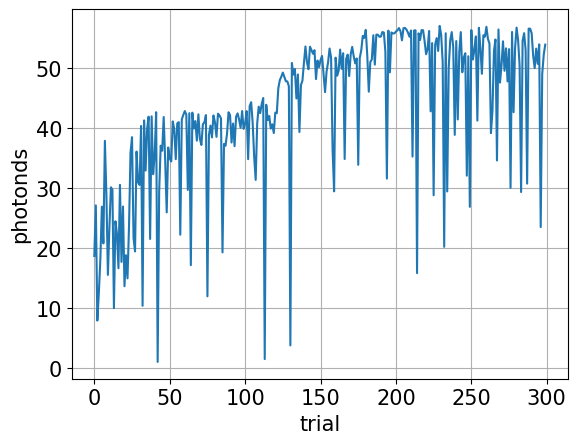

In [37]:
fig, ax = plt.subplots()
ax.plot(experiment.fetch_data().df["mean"])
ax.set_xlabel("trial")
ax.set_ylabel("photonds")
ax.grid()

In [38]:
render(plot_slice(model, "ΩQ0", "objective", slice_values=best_parameters))
render(plot_slice(model, "ΩQ1", "objective", slice_values=best_parameters))
render(plot_slice(model, "phase0", "objective", slice_values=best_parameters))
render(plot_slice(model, "phase1", "objective", slice_values=best_parameters))
render(plot_slice(model, "ton0", "objective", slice_values=best_parameters))
render(plot_slice(model, "ton1", "objective", slice_values=best_parameters))


In [39]:
render(
    plot_contour(
        model=model,
        param_x="ΩQ0",
        param_y="ΩQ1",
        metric_name="objective",
        slice_values=best_parameters,
    )
)

In [40]:
render(
    plot_contour(
        model=model,
        param_x="ton0",
        param_y="ton1",
        metric_name="objective",
        slice_values=best_parameters,
    )
)

In [41]:
render(
    plot_contour(
        model=model,
        param_x="ω0",
        param_y="ω1",
        metric_name="objective",
        slice_values=best_parameters,
    )
)